In [2]:
#### 벡터화

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 형태소 분석기
from konlpy.tag import Okt

# tf-idf를 이용한 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer

# 군집화
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 데이터 불러오기
df = pd.read_csv('./data/news_data.csv')

In [5]:
# 뉴스 기사에서 명사만 추출하기
okt = Okt()
noun_list = []
for content in tqdm(df['content']):
    nouns = okt.nouns(content)
    noun_list.append(nouns)
    
df["nouns"] = noun_list

100%|██████████████████████████████████████████████████████████████████████████████| 4501/4501 [12:23<00:00,  6.06it/s]


In [6]:
# 명사리스트가 비어 있으면 해당 인덱스 지우고 초기화
drop_index_list = []
for i, row in df.iterrows():
    temp_nouns = df['nouns']
    if len(temp_nouns) == 0: 
        drop_index_list.append(i)

df = df.drop(drop_index_list)

df.index = range(len(df))

In [26]:
# dataframe 내보내기(중간 저장)
df.to_csv("./data/df_vectorized.csv", index=False)

In [3]:
df = pd.read_csv("./data/df_vectorized.csv")

In [4]:
# 불용어 제거
li_stopwords = []
with open('./data/stopwords.txt', 'r', encoding = 'utf-8') as f:
    for line in f:
        li_stopwords.append(line.strip())
        
for i in range(len(df["nouns"])):
    df["nouns"][i] = [noun for noun in eval(df["nouns"][i]) if noun not in li_stopwords]

In [24]:
# 명사 벡터화
text = [" ".join(noun) for noun in df['nouns']]

tfidf_vectorizer = TfidfVectorizer(min_df = 7, ngram_range=(1,5))
tfidf_vectorizer.fit(text)
vector_dbscan = tfidf_vectorizer.transform(text).toarray()

In [25]:
vector_dbscan.shape

(4501, 39488)

In [26]:
#### 군집화

In [27]:
# DBSCAN : 중복 기사 제거
vector_dbscan = np.array(vector_dbscan)
model_dbscan = DBSCAN(eps=0.1,min_samples=1, metric = "cosine")
result_dbscan = model_dbscan.fit_predict(vector_dbscan)
df["cluster_dbscan"] = result_dbscan
df.head()

,url,title,date,content,nouns,cluster_dbscan
0,https://n.news.naver.com/mnews/article/001/001...,"이스라엘, 가자 '구호트럭 참사' 원인은 ""공격 아닌 압사""",2024-03-03,"""압사 방지 위한 경고 사격 후 약탈자들이 위협해 대응 사격"" 가자시티 구호 트럭...","[압사, 방지, 경고, 사격, 약탈, 위협, 사격, 시티, 구호, 트럭, 참사, 구...",0
1,https://n.news.naver.com/mnews/article/008/000...,"與윤재옥 ""김영주 부의장 입당, 우리 당 시야 넓히는 데 도움""",2024-03-03,"[the300] 현역 교체 비율 낮다는 지적에 ""국민들 눈높이에서 생각해보고 개선...","[현역, 교체, 비율, 지적, 눈높이, 개선, 개선, 윤재옥, 출입기자단, 비공개,...",1
2,https://n.news.naver.com/mnews/article/016/000...,빅5 대형병원도 응급실 '빨간불'…전임의 이탈 촉각,2024-03-03,"상급종합병원, 환자 더 줄일 듯정부 ""오늘까지 돌아오면 선처""거리 나온 의사들 ""...","[상급, 종합병원, 환자, 듯, 선처, 거리, 의사, 의대, 증원, 반대, 의대, ...",2
3,https://n.news.naver.com/mnews/article/031/000...,"대통령실 ""의대 증원 2천명 변화 없어…비수도권 집중 배치""",2024-03-03,"현장 복귀 안한 전공의 ""법과 원칙에 따른 절차 불가피""성태윤 대통령실 정책실장은...","[복귀, 전공, 원칙, 불가피, 성태, 윤, 대통령실, 실장, 의대, 증원, 자세,...",3
4,https://n.news.naver.com/mnews/article/001/001...,먹과 두드림으로 기록하는 역사…국보 정림사지 석탑 탁본 뜬다,2024-03-03,"문화재위원회, 총 4건 금석문 탁본 허가…고대사·서예사 연구에 도움 국보 '부여 ...","[문화재, 총, 금석문, 탁본, 허가, 대사, 예사, 연구, 도움, 국보, 부여, ...",4


In [28]:
# 클러스터링 결과 확인
for cluster_num in set(result_dbscan):
    # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
    if(cluster_num == -1 or cluster_num == 0):
        continue
    else:
        print(f"cluster num : {cluster_num}")
        temp_df = df[df['cluster_dbscan'] == cluster_num]
        for title in temp_df['title']:
            print(title)
        print()

cluster num : 1
與윤재옥 "김영주 부의장 입당, 우리 당 시야 넓히는 데 도움"

cluster num : 2
빅5 대형병원도 응급실 '빨간불'…전임의 이탈 촉각

cluster num : 3
대통령실 "의대 증원 2천명 변화 없어…비수도권 집중 배치"

cluster num : 4
먹과 두드림으로 기록하는 역사…국보 정림사지 석탑 탁본 뜬다

cluster num : 5
막 오르는 '주총 시즌'…소액주주 입김 세지나
‘밸류업’ 기조로 주주연대 탄력…자기주식 취득·소각 등 주주제안 [투자360]
주총시즌 소액주주운동 '불길'…경영권 분쟁속 대주주 '러브콜'도

cluster num : 6
“전쟁 난 줄, 차 날아가” 14명 사상 추돌사고 CCTV 영상 보니

cluster num : 7
대법 "지급보증수수료는 이자소득 아닌 기타소득"… "중국 과세권 없어"
한화솔루션 "1억671만42원 세금 돌려줘" 소송…대법 "과세 정당"
한화솔루션 "1억여원 세금 반환" 소송서 패소…대법 "과세 정당"

cluster num : 8
길에서 주운 2억짜리 명품시계… 6개월 뒤 소유권은 누구 손에? [법조 인앤아웃]

cluster num : 9
의사들, 끝내 병원 대신 거리로… 정부, 전공의 사법 처리 착수

cluster num : 10
이상민 “오늘까지 복귀하는 전공의 최대한 선처”…4일부터 행정·사법 절차 돌입

cluster num : 11
"애드립 할 수 있게 해주세요!" '입틀막 정권' 풍자한 SNL코리아

cluster num : 12
김영주, 4일 국민의힘 입당 "중도층 외연확장"…박민식은 강서을 출마

cluster num : 13
공부방 제자들 어깨·팔 주무르며 추행한 50대…법원, 징역 2년6개월 선고
"학원 적응했어?" 공부방 제자들 어깨·팔 주무르며 추행한 50대
"적응했어?" 공부방 10대 제자들 상습 추행한 50대의 최후
“학원 적응 잘 했어?” 어린 女제자들 가슴 만진 공부방 운영자
"왜 틀렸어?" 물으며 11살 제자 추행한 공부방 

中, 정협 상무위 폐막으로 양회 사전준비 사실상 완료

cluster num : 1042
'진짜 민주'·'개혁보수'...제3지대 존재감 경쟁 사활

cluster num : 1043
[시끌시끌 이 단지]수평증축 적용 ‘개포 더샵트리에’는 되고 다른 곳은 안 된다?

cluster num : 1044
"저는 의새입니다" 의사들 챌린지 확산

cluster num : 1045
복귀 시한 이틀 지나 집단행동 12일째...이 시각 서울대병원

cluster num : 1046
몰카로 경찰 조사 앞두고 또 몰카 범행...50대 법정구속

cluster num : 1047
[영상] 흉기 들고 지구대 들어가려던 50대 마약범

cluster num : 1048
패전 후 일본인 71만명, 단돈 1000엔씩 들고 조선을 떠났다

cluster num : 1049
선거 때마다 쏟아지는 ‘공약’…‘재원 방안’은 허술
선거 때마다 쏟아지는 ‘공약’…‘재원 방안’은 허술 [정치개혁 K 2024]

cluster num : 1050
1기 신도시 사업성 확보 위해 "각종 부담금 감면 필요"

cluster num : 1051
행안부, '공인재난관리사 자격시험제도' 기반 마련
공인재난관리사 자격시험 도입…재난안전법 개정안 통과
‘공인재난관리사’ 생긴다
"재난관리 전문가 양성 위한 기반 마련"…재난안전법 국회 통과

cluster num : 1052
2기 공수처장 인선 '초읽기'…조직 안정 급선무, '반쪽' 수사권 해결해야

cluster num : 1053
주택임대인의 실거주 의사의 존재를 인정하기 위한 요건[이철웅의 법으로 읽는 부동산]

cluster num : 1054
흉기 들고 지구대 난입시도 한 50대 검거…마약 '양성' 반응

cluster num : 1055
부산 돌려차기 피해자, 작가로 돌아와…‘싸울게요 안 죽었으니까’출간

cluster num : 1056
전공의 80% 사직서 낸 대전 병원 응급실… 새벽부터 환자 잇따라

cluster num : 1057
음주운전으로 수

車제작사, 자율주행차 성능 별도 인증받으면 판매 가능해진다

cluster num : 2289
윤재옥, '쌍특검법' 재표결 앞두고 "중요한 표결, 오늘 정리돼야"

cluster num : 2290
여야, ‘선거구 획정안’ 극적 타결…‘쌍특검법’ 본회의 재표결

cluster num : 2291
이방인이 되는 시간을 건너는 법

cluster num : 2292
'한동훈 독직폭행 무죄' 정진웅 검사 정직 2개월 징계
'한동훈 독직폭행 무죄' 정진웅 검사 정직 2개월 징계
'한동훈 독직폭행' 정진웅 검사 무죄 받고도 정직 2개월 중징계
대법 ‘무죄’에도…정진웅 ‘한동훈 독직폭행’ 중징계, 왜
‘한동훈 독직폭행 무죄’ 확정 정진웅 검사, 정직 2개월
'한동훈 독직폭행 무죄' 정진웅 검사, 정직 2개월 중징계
'한동훈 독직폭행 혐의' 무죄인데…정진웅 '정직 2개월' 중징계, 왜?

cluster num : 2293
불타는 차량 두고 달아난 운전자, 10시간 만에 긴급체포

cluster num : 2294
[속보] '김건희 여사 특검법' 국회 재표결서 부결

cluster num : 2295
“유예 법안 즉각 처리를”…여경협, 중대재해처벌법 유예 촉구

cluster num : 2296
스쿨존서 초등학생 치어 숨지게 40대 만취 운전자 징역 5년 확정…뺑소니는 무죄
'강남 스쿨존 사망사고' 음주운전자 징역 5년 확정…뺑소니 무죄(종합)

cluster num : 2297
檢, 3만9000명 환자 개인정보 빼돌린 제약사·학교법인 기소
‘3만9000명 환자정보 유출’ 대학병원·제약사 법인 불구속기소

cluster num : 2298
신안군, 건축물대장이 있는 토지, 지목변경 신청하세요

cluster num : 2299
환경오염 피해·분쟁 접수, '환경분쟁조정피해구제위원회' 일원화
환경피해 발생 시 원스톱·신속 구제…환경분쟁조정법 등 본회의 통과

cluster num : 2300
여, 29일 '김건희 특검법' 빨간불에 강남·영남 공천 속도 주목

cluster nu

민주노총 "22대 국회 우선 입법과제는 노란봉투법·주4일제"

cluster num : 3530
부안군, 특례 발굴 위한 군민 의견 듣는다

cluster num : 3531
'후보자' 아닌 한동훈, '국민의미래' 선거운동도 나선다

cluster num : 3532
'기업혁신파크' 공공폐수처리시설 설치비 국비 지원

cluster num : 3533
'중국 경유는 눈속임'…러시아에 '전략물자' 밀수출한 부자

cluster num : 3534
“화 나면 술 마시고 운전”… 상습 음주운전자, 부산 첫 차량 압수

cluster num : 3535
전세사기 先구제법, 野 단독으로 본회의 올려

cluster num : 3536
[의대증원 파장] 전공의 법적조치 초읽기에 교수 등판 조짐…장기화 분수령(종합)

cluster num : 3537
“임대차 계약갱신 청구권·전월세 상한제 합헌”

cluster num : 3538
음주운전 6번 걸리고도 또…주차 차량 들이받고 '쿨쿨' 40대 구속

cluster num : 3539
전쟁 중인 러시아에 ‘파괴무기’ 제조 가능 정밀기계 밀수출한 父子

cluster num : 3540
'검단 붕괴' GS건설 영업정지 제동…法 "회복 어려운 손해 우려"(종합)

cluster num : 3541
EU, 'MS-미스트랄 AI 파트너십' 조사 가능성

cluster num : 3542
플랫폼에 눌리고, 재벌에 꺾이고…윤 정부의 공정위 ‘무뎌진 칼날’

cluster num : 3543
'성관계 영상 유포·협박' 황의조 형수 오늘 재판…증인으로 친형 나온다

cluster num : 3544
익산시, 전북특별자치도 2차 특례 발굴 '집중'

cluster num : 3545
유니온커뮤니티 “ISO 2종 인증 획득, GDPR 준수 앞장선다”

cluster num : 3546
국회에서 재생된 '김건희 디올백 영상'…국힘 반발 "법카로 과일 1천만원 사 먹은 분도…"

cluster num : 3547
[스브스픽] 악플러 고소한 주호

In [29]:
# 군집 별 대표 기사 추출
def print_cluster_result(train, result):
    clusters = []
    counts = []
    top_title = []
    top_noun = []
    for cluster_num in set(result):
        # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
        if(cluster_num == -1 or cluster_num == 0): 
             continue
        else:
            temp_df = train[train['cluster_dbscan'] == cluster_num]
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            top_title.append(temp_df.reset_index()['title'][0])
            top_noun.append(temp_df.reset_index()['nouns'][0])


    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'top_title':top_title, 'top_noun':top_noun})
    return cluster_result

cluster = print_cluster_result(df, result_dbscan)
cluster

,cluster_num,count,top_title,top_noun
0,1,1,"與윤재옥 ""김영주 부의장 입당, 우리 당 시야 넓히는 데 도움""","[현역, 교체, 비율, 지적, 눈높이, 개선, 개선, 윤재옥, 출입기자단, 비공개,..."
1,2,1,빅5 대형병원도 응급실 '빨간불'…전임의 이탈 촉각,"[상급, 종합병원, 환자, 듯, 선처, 거리, 의사, 의대, 증원, 반대, 의대, ..."
2,3,1,"대통령실 ""의대 증원 2천명 변화 없어…비수도권 집중 배치""","[복귀, 전공, 원칙, 불가피, 성태, 윤, 대통령실, 실장, 의대, 증원, 자세,..."
3,4,1,먹과 두드림으로 기록하는 역사…국보 정림사지 석탑 탁본 뜬다,"[문화재, 총, 금석문, 탁본, 허가, 대사, 예사, 연구, 도움, 국보, 부여, ..."
4,5,3,막 오르는 '주총 시즌'…소액주주 입김 세지나,"[밸류업, 기조, 주주, 제안, 분주, 표, 대결, 투자, 고려아연, 선대, 주주,..."
...,...,...,...,...
3685,3686,1,전공의 '사법절차' 최후통첩…'29일 복귀' 마지노선 임박,"[전공, 집단, 이탈, 장기, 가운데, 대구, 대학병원, 응급실, 의료, 진, 모습..."
3686,3687,1,"내일 쌍특검법 재표결, 野 선거구획정 연계에 무산 가능성(종합)","[선거구, 획정, 특검법, 표결, 해, 선거법, 총선, 제대로, 수도, 계, 내일,..."
3687,3688,1,"생후 2개월도 안 된 쌍둥이 자매, 침대에 엎어 재워 숨지게 한 20대 엄마","[검찰, 살인, 고의, 인정, 자료, 생후, 개월, 쌍둥이, 자매, 모텔, 침대, ..."
3688,3689,1,"대한간호협회 ""정부 의료개혁 지지""… 간호법 제정도 추진","[간호사, 시범, 긍정, 간호, 제정, 최선, 간호, 간호사, 시범, 환영, 뜻, ..."


In [31]:
# K-MEANS
# 대표 기사들 대상 명사 벡터화
text = [" ".join(noun) for noun in cluster['top_noun']]

tfidf_vectorizer = TfidfVectorizer(min_df = 7, ngram_range=(1,5))
tfidf_vectorizer.fit(text)
vector_kmeans = tfidf_vectorizer.transform(text).toarray()

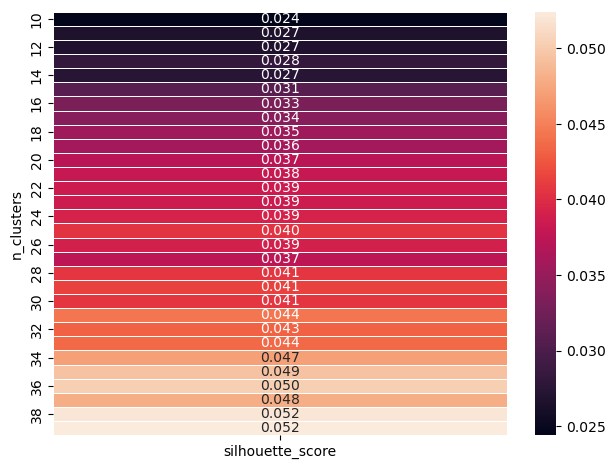

In [32]:
# 가장 높은 silhouette score를 가지는 k값 찾기
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(10, 25)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()
    return pivot_km

pivot_km = visualize_silhouette_layer(vector_kmeans)

In [33]:
k = pivot_km[pivot_km.silhouette_score == max(pivot_km.silhouette_score)].reset_index().loc[0, "n_clusters"]
result_kmeans = KMeans(n_clusters=K).fit_predict(vector_kmeans)
cluster['cluster_kmeans'] = result_kmeans

In [34]:
# K-Means clustering 결과 출력
for i in set(cluster.cluster_kmeans):
    print(f"cluster : {i}")
    print(cluster[cluster.cluster_kmeans == i].top_title)
    print("------------------------------")

cluster : 0
41       '태아 성감별 금지 위헌' 이끈 부부변호사…아내는 산후조리원서 '환호'
187     [횡설수설/신광영]“태아 성별과 낙태는 무관”… 이젠 여아 선호가 걱정?
1386       태아 성별 확인 금지법 위헌 판결… 성별을 이유로 한 낙태 가능성은
1489                      [천자칼럼] 성감별 금지법은 사라졌지만…
1947              “구닥다리 법 사라져”“낙태 줄일 감정 시기 논의해야”
                          ...                   
3594           태아 성별 고지 금지 37년 만에 위헌…“남아선호사상 쇠퇴”
3603       태아 성별 언제든 알 수 있다…"임신 32주 전 감별 금지는 위헌"
3627           [속보]헌재 “‘32주 전 태아 성감별 금지’ 의료법 위헌”
3653                  [속보]헌재, '태아 성감별 금지법' 위헌 결정
3682          헌재 “임신 32주 전 ‘태아 성 감별’ 금지한 의료법 위헌”
Name: top_title, Length: 72, dtype: object
------------------------------
cluster : 1
82                  오늘 여의도에 의사 2만명 집결...정부·의사 갈등 최고조
167                 정부, 의학드라마 명대사 인용…"의사가 마지막 희망입니다"
169              오늘 의사 2만명 여의도 집회 예정… 정부 ‘강경 대응’ 본격화
403              '김사부‧슬의생' 명대사까지 동원한 정부.."60만명 지켜봤다"
410                의사 2만 명, 오늘 총궐기대회…압수수색 이후 '갈등 고조'
553            '슬의생' 대사로 전공의 복귀 호소한 정부…'우리 곁으로 돌아와라'
698              의사 2만명 모이는 집회…이렇게 하면 '불법 집회'

In [35]:
# clustering result 원래 데이터프레임에 추가
for i in range(len(df)):
    if (df.loc[i, "cluster_dbscan"] == 0):
        continue
    df_cluster = cluster[cluster.cluster_num == df.loc[i, "cluster_dbscan"]]
    df_cluster.reset_index()
    df.loc[i, "cluster"] = df_cluster.iloc[0]["cluster_kmeans"]

In [36]:
# 클러스터 내부 원소 간 거리 가장 큰 군집 버리기
# 각 클러스터 내부 원소 간의 거리 출력
cluster_label_ = []
distance_ = []
len_cluster_ = []

for cluster_label in np.unique(result_kmeans):
    cluster_indices = np.where(result_kmeans == cluster_label)[0]
    cluster_vector = vector_kmeans[cluster_indices, :]
    distances = pairwise_distances(cluster_vector, metric='euclidean')
    avg_distance_within_cluster = np.mean(distances)
    len_cluster_.append(cluster_vector.shape[0])
    cluster_label_.append(cluster_label)
    distance_.append(avg_distance_within_cluster)
    print(f'Average distance within cluster {cluster_label}: {avg_distance_within_cluster}')
    
distance = pd.DataFrame({"cluster_label" : cluster_label_, "distance" : distance_, "length" : len_cluster_})

Average distance within cluster 0: 1.0161852312621964
Average distance within cluster 1: 1.2714126741214877
Average distance within cluster 2: 1.1857497214540578
Average distance within cluster 3: 1.072875442662769
Average distance within cluster 4: 1.2158251119973664
Average distance within cluster 5: 1.1614626270481578
Average distance within cluster 6: 1.3987847227994168
Average distance within cluster 7: 1.234482841353996
Average distance within cluster 8: 1.2892957200008828
Average distance within cluster 9: 1.1189695358540983
Average distance within cluster 10: 1.2868701386017503
Average distance within cluster 11: 1.1303665696877778
Average distance within cluster 12: 1.28823449583649
Average distance within cluster 13: 1.360678123644268
Average distance within cluster 14: 1.1606843181767599
Average distance within cluster 15: 1.3343958485720009
Average distance within cluster 16: 1.0671543927179592
Average distance within cluster 17: 1.1576135011252378
Average distance within c

In [37]:
distance[distance['distance'] == max(distance['distance'])]['cluster_label']

6    6
Name: cluster_label, dtype: int32

In [38]:
df.to_csv("./data/df_cluster.csv", index=False)
pd.read_csv("./data/df_cluster.csv")

,url,title,date,content,nouns,cluster_dbscan,cluster
0,https://n.news.naver.com/mnews/article/001/001...,"이스라엘, 가자 '구호트럭 참사' 원인은 ""공격 아닌 압사""",2024-03-03,"""압사 방지 위한 경고 사격 후 약탈자들이 위협해 대응 사격"" 가자시티 구호 트럭...","['압사', '방지', '경고', '사격', '약탈', '위협', '사격', '시티...",0,NaN
1,https://n.news.naver.com/mnews/article/008/000...,"與윤재옥 ""김영주 부의장 입당, 우리 당 시야 넓히는 데 도움""",2024-03-03,"[the300] 현역 교체 비율 낮다는 지적에 ""국민들 눈높이에서 생각해보고 개선...","['현역', '교체', '비율', '지적', '눈높이', '개선', '개선', '윤...",1,11.0
2,https://n.news.naver.com/mnews/article/016/000...,빅5 대형병원도 응급실 '빨간불'…전임의 이탈 촉각,2024-03-03,"상급종합병원, 환자 더 줄일 듯정부 ""오늘까지 돌아오면 선처""거리 나온 의사들 ""...","['상급', '종합병원', '환자', '듯', '선처', '거리', '의사', '의...",2,8.0
3,https://n.news.naver.com/mnews/article/031/000...,"대통령실 ""의대 증원 2천명 변화 없어…비수도권 집중 배치""",2024-03-03,"현장 복귀 안한 전공의 ""법과 원칙에 따른 절차 불가피""성태윤 대통령실 정책실장은...","['복귀', '전공', '원칙', '불가피', '성태', '윤', '대통령실', '...",3,8.0
4,https://n.news.naver.com/mnews/article/001/001...,먹과 두드림으로 기록하는 역사…국보 정림사지 석탑 탁본 뜬다,2024-03-03,"문화재위원회, 총 4건 금석문 탁본 허가…고대사·서예사 연구에 도움 국보 '부여 ...","['문화재', '총', '금석문', '탁본', '허가', '대사', '예사', '연...",4,6.0
...,...,...,...,...,...,...,...
4496,https://n.news.naver.com/mnews/article/001/001...,유럽의회서 '자연 복원법' 가결…우파 폐기 시도 무산,2024-02-28,2030년까지 육지·바다 20% 복원…기후 중립 달성 핵심 법안 유럽의회 [유럽의...,"['육지', '바다', '복원', '기후', '중립', '달성', '핵심', '유럽...",3639,6.0
4497,https://n.news.naver.com/mnews/article/277/000...,"대한간호협회 ""정부 의료개혁 지지""… 간호법 제정도 추진",2024-02-28,"간호사 업무 관련 시범사업에 '긍정'""간호법 제정에 최선 다하겠다""간호계가 정부의...","['간호사', '시범', '긍정', '간호', '제정', '최선', '간호', '간...",3689,6.0
4498,https://n.news.naver.com/mnews/article/001/001...,[전국 주요 신문 톱뉴스](28일 조간),2024-02-28,▲ 경향신문 = 쫓겨날까 하루하루 불안 특별법에도 변한 게 없다 ▲ 국민일보 = ...,"['경향신문', '하루하루', '불안', '특별법', '국민일보', '임종석', '...",3690,6.0
4499,https://n.news.naver.com/mnews/article/119/000...,올 7월 내부자거래 사전공시제도 의무화…연기금 등은 면제,2024-02-28,자본시장법 하위법령 개정안 입법예고최소 30일 전에 계획 보고해야…과징금 최대 2...,"['자본시장', '하위', '법령', '입법', '예고', '최소', '보고', '...",3212,20.0
